In [3]:
import os
import time
from typing import Union

import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
from model import UNet
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfms
from tqdm import tqdm

In [4]:
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 1 NVIDIA GeForce RTX 3090


In [11]:
INIT_LR = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 64
IMG_SIZE = 448
EXP_NAME = "exp7"

raw_images = np.concatenate([np.load("ct2019.npy"), np.load("ct2020.npy")], axis=0)
raw_masks = np.concatenate([np.load("mask2019.npy"), np.load("mask2020.npy")], axis=0)
split = 3000

print(raw_images.shape, raw_masks.shape)

(3760, 1, 512, 512) (3760, 1, 512, 512)


In [13]:
class SegmentationDataset(Dataset):
    def __init__(self,
                 images,
                 masks,
                 start=0,
                 end=2329,
                 hu1=-900,
                 hu2=100,
                 xfm: Union[xfms.ToTensor, xfms.Compose] = xfms.ToTensor(),
                 xfm_img=None):
        self.xfm = xfm
        self.xfmi = xfm_img
        self.start = start
        self.end = end
        self.hu1 = hu1
        self.hu2 = hu2

        self.imgs = images[start:end]
        self.masks = masks[start:end]

        assert self.imgs.shape == self.masks.shape, f"imgs {self.imgs.shape} != masks {self.masks.shape}"

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = (self.imgs[idx][0].clip(self.hu1, self.hu2) - self.hu1) / (self.hu2 - self.hu1)
        mask = self.masks[idx][0]
        seed = torch.random.seed()

        torch.random.manual_seed(seed)
        img = self.xfm(img.astype(np.float32))

        torch.random.manual_seed(seed)
        mask = self.xfm(mask.astype(np.float32))

        if self.xfmi is not None:
            img = self.xfmi(img)
        return (img, mask)

torch.Size([64, 1, 448, 448]) torch.Size([64, 1, 448, 448])


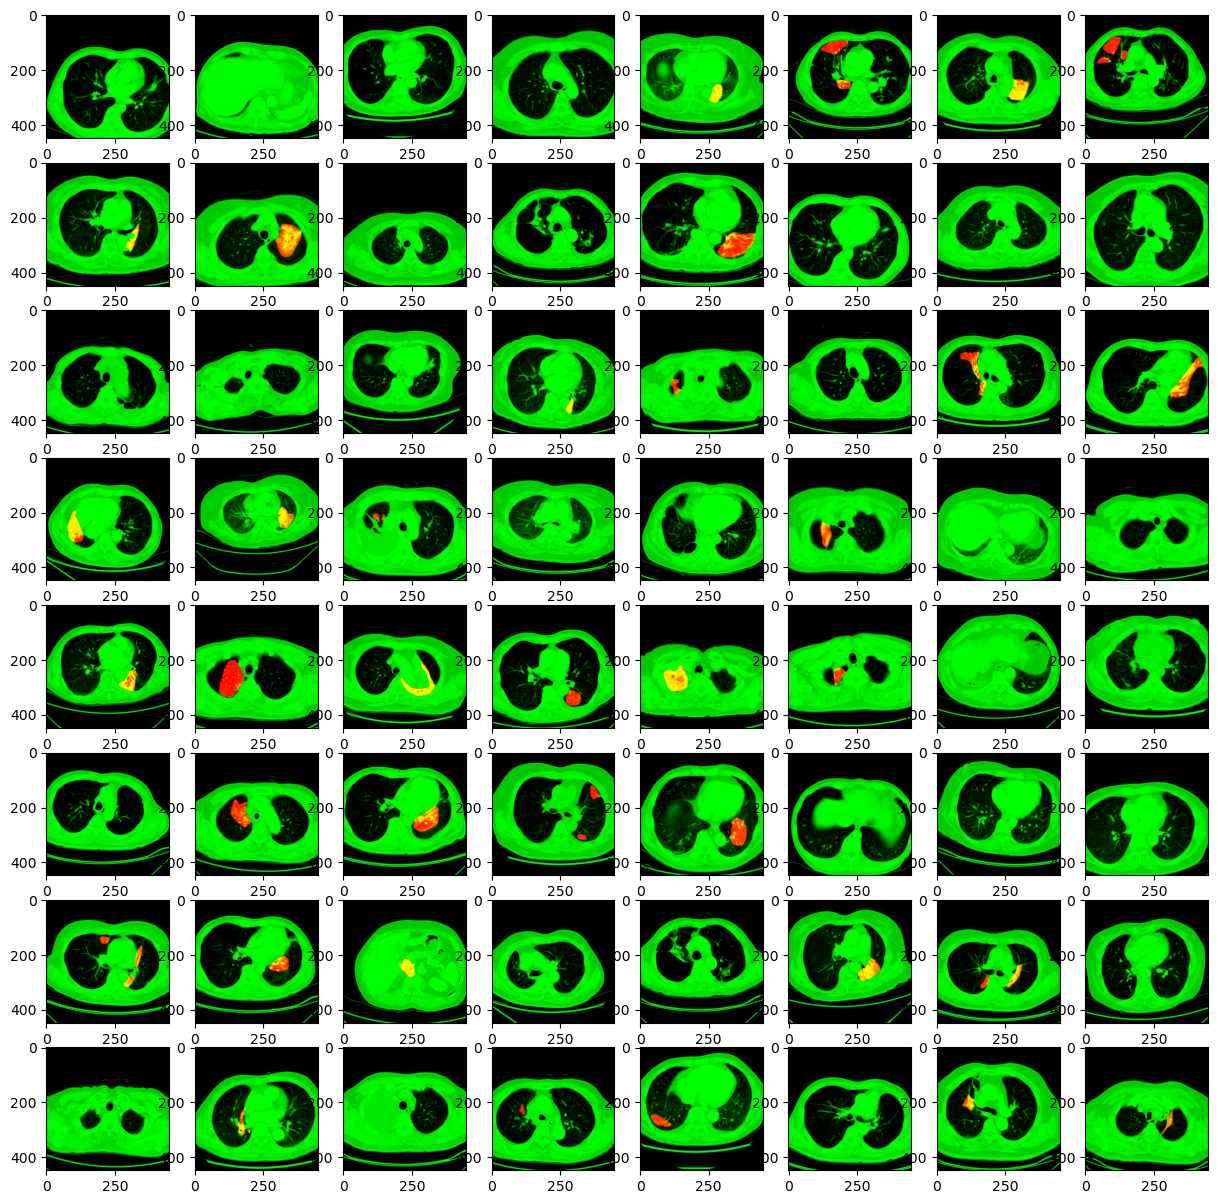

In [19]:
tds = SegmentationDataset(
    images=raw_images,
    masks=raw_masks,
    start=0,
    end=split,
    hu1=-900,
    hu2=100,
    xfm=xfms.Compose([xfms.ToTensor(), xfms.Resize((512, 512)),
                      xfms.RandomCrop((IMG_SIZE, IMG_SIZE))]),
    xfm_img=xfms.Compose([xfms.Normalize(0.5, 0.5)]),
)
tdl = DataLoader(tds, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)

vds = SegmentationDataset(
    images=raw_images,
    masks=raw_masks,
    start=split,
    end=-1,
    hu1=-900,
    hu2=100,
    xfm=xfms.Compose([xfms.ToTensor(), xfms.Resize((512, 512)),
                      xfms.RandomCrop((IMG_SIZE, IMG_SIZE))]),
    xfm_img=xfms.Compose([xfms.Normalize(0.5, 0.5)]),
)
vdl = DataLoader(vds, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True)

for i, (imgs, masks) in enumerate(tdl):
    print(imgs.shape, masks.shape)
    plt.figure(figsize=(15, 15))
    for ii, (img, mask) in enumerate(zip(imgs, masks)):

        plt.subplot(8, 8, ii + 1)
        plt.imshow(
            einops.rearrange(np.array([mask.numpy()[0],
                                       img.numpy()[0] / 2 + 0.5,
                                       np.zeros((IMG_SIZE, IMG_SIZE))]), "c h w -> h w c"))
    break

In [20]:
unet = torch.nn.DataParallel(UNet(encChannels=(1, 16, 32, 64), outSize=(IMG_SIZE, IMG_SIZE)).to(device), device_ids=[1, 0])
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
H = {"train_loss": [], "test_loss": []}

In [21]:
# train
print("[INFO] training the network...")
startTime = time.time()
e_bar = tqdm(range(NUM_EPOCHS))
for e in e_bar:
    unet.train()
    totalTrainLoss = torch.Tensor([0]).to(device)
    totalTestLoss = torch.Tensor([0]).to(device)
    for (i, (x, y)) in enumerate(tdl):
        (x, y) = (x.to(device), y.to(device))s
        pred = unet(x)
        loss = lossFunc(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss

    with torch.no_grad():
        unet.eval()
        for (x, y) in vdl:
            (x, y) = (x.to(device), y.to(device))
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
            
    # calculate the average training and validation loss
    avgTrainLoss = (totalTrainLoss.cpu().item() / len(tdl))
    avgTestLoss = (totalTestLoss.cpu().item() / len(vdl))
    if H["test_loss"] and avgTestLoss < np.min(H["test_loss"]):
        torch.save(unet.state_dict(), f"exp7/{avgTestLoss:.4f}_{e+1:03}.pth")
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["test_loss"].append(avgTestLoss)
    # print the model training and validation information
    e_bar.set_description(f"#{e+1:03}, tl:{avgTrainLoss:.4f}, vl:{avgTestLoss:.4f}")
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


#100, tl:0.0276, vl:0.0245: 100%|██████████| 100/100 [16:51<00:00, 10.11s/it]

[INFO] total time taken to train the model: 1011.18s


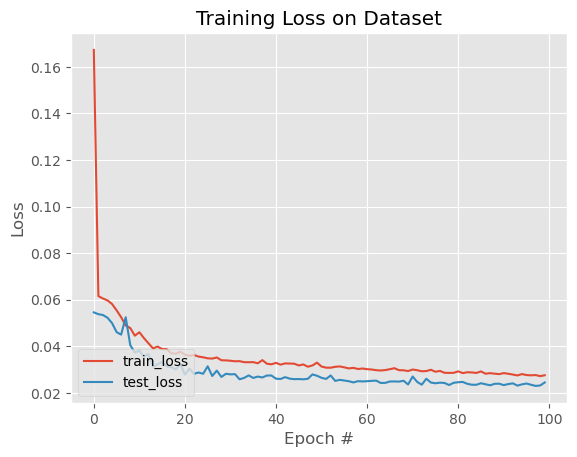

In [22]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("exp7.png")

In [65]:
unet.load_state_dict(torch.load("/root/projs/rili/RILI-2019-2020/exp7/0.0230_098.pth"))

<All keys matched successfully>

In [114]:
# eval
th = 0
totalTestLoss, dices, ious = 0, 0, 0
best = []
n = 5
best_5n = []
now_n = []
with torch.no_grad():
    unet.eval()
    for i, (x, y) in enumerate(vdl):
        (x, y) = (x.to(device), y.to(device))
        pred = unet(x)
        totalTestLoss += lossFunc(pred, y)
        # plt.figure(figsize=(15, 15))
        for ii, (xx, yy, pp) in enumerate(zip(x.cpu().numpy(), y.cpu().numpy(), pred.cpu().numpy())):

            pp2 = np.zeros((1, IMG_SIZE, IMG_SIZE))

            pc, _ = cv2.findContours(np.array(pp[0] > th, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            for c in pc:
                if cv2.contourArea(c) > 500:
                    cv2.fillPoly(pp2[0], [c], 1)

            pp = pp2

            # dice = (np.sum(yy[[pp[0] > th]]) * 2 + 0.1) / ((np.sum(yy[0]) + np.sum(pp[0] > th)) + 0.1)
            dice = (np.sum(yy[pp == 1]) * 2 + 0.1) / ((np.sum(yy[0]) + np.sum(pp)) + 0.1)
            iou = (dice + 0.001) / (2.001 - dice)

            dices += dice
            ious += iou

            if iou < 1:

                if (len(best) < 5 or best[-1][0] < iou) and iou != 1:
                    best.append([iou, dice, xx, yy, pp])
                    best = sorted(best, key=lambda x: x[0], reverse=True)
                    if len(best) > 5:
                        best.pop()

                if len(now_n) == n:
                    if len(best_5n) <= 5 or sum(k[1] for k in best_5n[-1]) < sum(k[1] for k in now_n):
                        best_5n.append(now_n.copy())
                    if len(best_5n) > 5:
                        best_5n = sorted(best_5n, key=lambda x: sum(k[1] for k in x), reverse=True)
                        rule = best_5n[0][2][-1]
                        rm_tmp = []
                        for ki, k in enumerate(best_5n[1:]):
                            if abs(k[2][-1] - rule) < 15:
                                rm_tmp.append(ki + 1)
                        for kki, ki in enumerate(rm_tmp):
                            best_5n.remove(best_5n[ki - kki])
                        if len(best_5n) > 5:
                            best_5n.pop()
                    now_n.remove(now_n[0])
                now_n.append([iou, dice, xx, yy, pp, i * 64 + ii])
print(f"avg Dice = {dices/len(vds):.4f}, avg IoU = {ious/len(vds):.4f}, Valid Loss = {totalTestLoss/len(vdl):.4f}, ")

avg Dice = 0.6405, avg IoU = 0.5789, Valid Loss = 0.0230, 


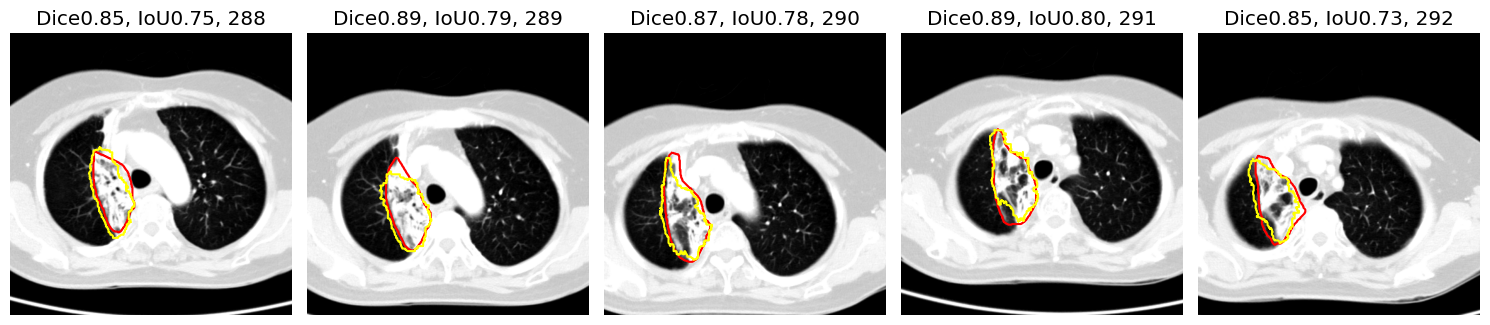

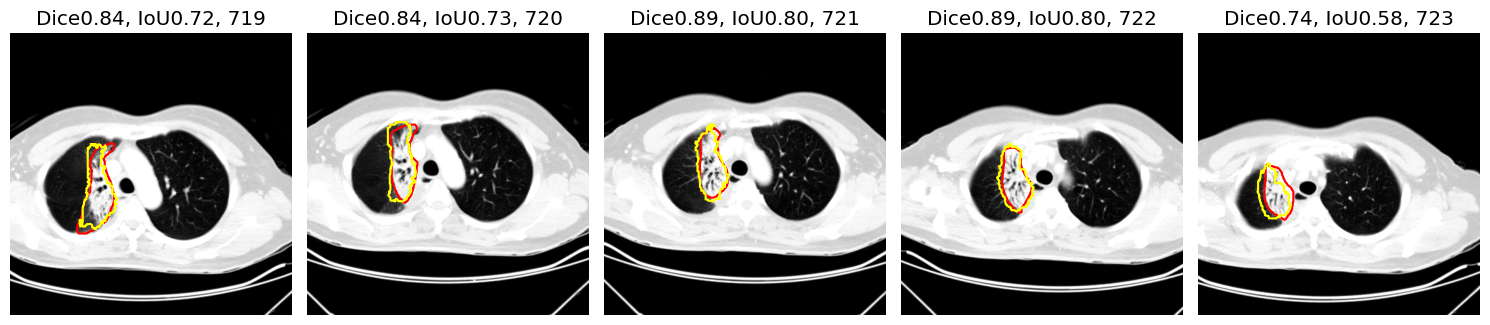

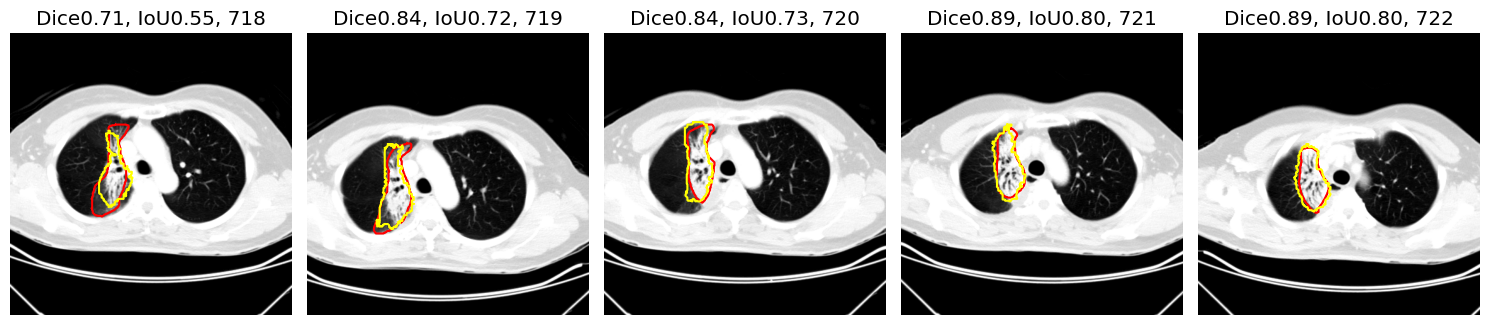

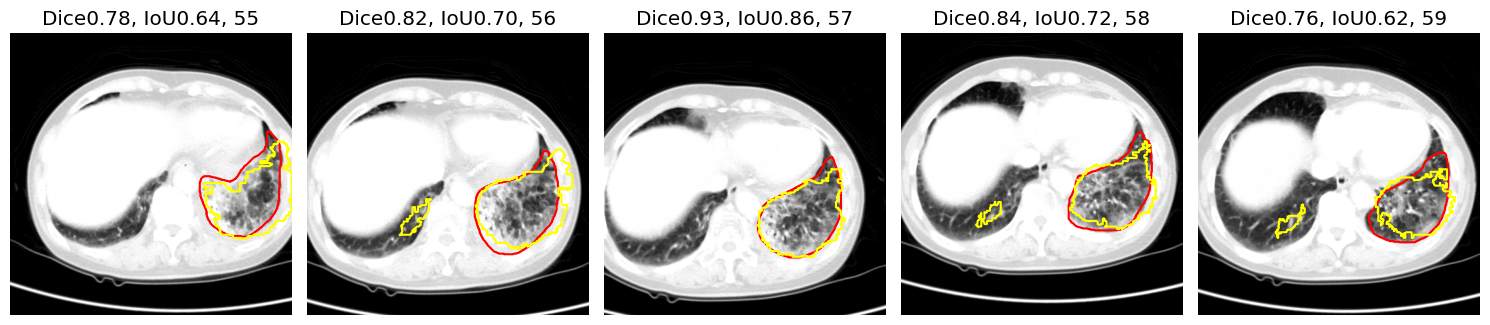

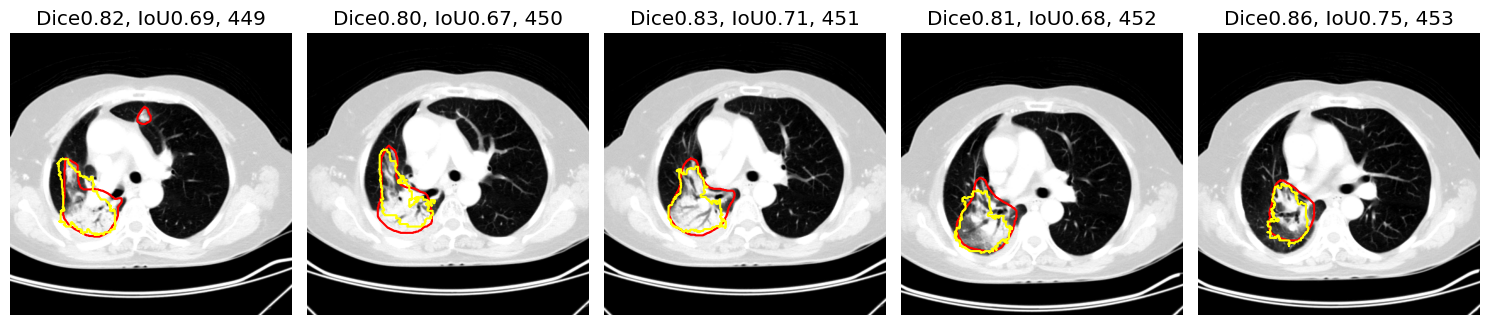

In [116]:
for i in range(5):
    plt.figure(figsize=(15, 5))
    for ii, (iou, dice, xx, yy, pp, hi) in enumerate(best_5n[i]):

        plt.subplot(1, n, ii + 1)
        plt.imshow(einops.rearrange([xx[0] / 2 + 0.5] * 3, "c h w -> h w c"))

        yc, _ = cv2.findContours(np.array(yy[0], np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in yc:
            plt.plot(c[:, 0, 0], c[:, 0, 1], color="red")

        pc, _ = cv2.findContours(np.array(pp[0] > th, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in pc:
            plt.plot(c[:, 0, 0], c[:, 0, 1], color="yellow")

        plt.title(f"Dice{dice:.2f}, IoU{iou:.2f}, {hi}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"exp7_5_{i}.png")
    plt.show()